In [1]:
# Autor: Elvis do A. Soares
# Github: @elvissoares
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science','notebook'])

# Dinâmica Molecular no Ensemble NVT

- $N$: número de partículas
- $V$: volume 
- $T$: temperatura


## Integrador de Langevin

A dinâmica de Langevin é dada por 

$$dq = p dt$$
$$dp = - \nabla U(x) dt - \gamma p dt + \left(2 \gamma k_B T m\right)^{1/2} dW$$

onde $\gamma$ é um coeficiente de atrito e $dW$ é um processo estocástico gerado a partir de um número aleatório gaussiano com média 

$$\langle dW \rangle = 0$$

e variância 

$$\langle dW^2 \rangle = dt^2$$

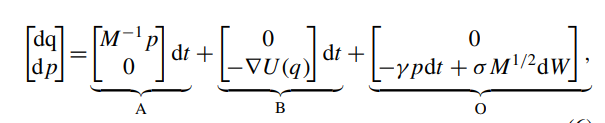

Função que calcula o potencial de LJ entre pares

In [2]:
def ulj(r,epsilon=1.0,sigma=1.0):
    return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

Função que calcula a derivada do potencial de LJ entre pares

In [3]:
def duljdr(r,epsilon=1.0,sigma=1.0):
    return -48*epsilon*((sigma/r)**12-0.5*(sigma/r)**6)/r

In [ ]:
class LJsystem():
    # Função que cria a classe
    def __init__(self,N_atoms, m = 1.0, epsilon = 1.0, sigma = 1.0, rcut = 2.5):
        self.N_atoms = N_atoms

        # parametros dos atomos
        self.m = m*np.ones(self.N_atoms)
        self.sigma = sigma*np.ones(self.N_atoms)
        self.epsilon = epsilon*np.ones(self.N_atoms)

        # parametro de Langevin
        self.gamma = 0.3

        # parametro de cutoff da interação de LJ
        self.rcut = rcut

        # Arrays de posições
        self.x = np.zeros(self.N_atoms)
        self.y = np.zeros(self.N_atoms)
        self.z = np.zeros(self.N_atoms)

        # Arrays de velocidade
        self.vx = np.zeros(self.N_atoms)        
        self.vy = np.zeros(self.N_atoms) 
        self.vz = np.zeros(self.N_atoms) 

        # Arrays de aceleração
        self.ax = np.zeros(self.N_atoms)        
        self.ay = np.zeros(self.N_atoms)
        self.az = np.zeros(self.N_atoms)

    def Set_Density(self,rho):
        self.rho = rho
        # calcular o tamanho da caixa necessária 
        self.Vol = self.N_atoms/self.rho
        self.Lx = self.Ly = self.Lz = np.power(self.N_atoms/self.rho,1/3.0)

    def Initialize_Positions(self):
        # Número de pontos em x e y
        Nx = Ny = Nz = int(np.ceil(np.power(self.N_atoms/4,1/3.0)))

        # Espaçamento entre os átomos
        dx = self.Lx/Nx
        dy = self.Ly/Ny
        dz = self.Lz/Nz

        # Posições possíveis em x e y numa rede cristalina tipo FCC
        id = 0
        for i in range(Nx):
            for j in range(Ny):
                for k in range(Nz):
                    if (id < self.N_atoms):
                        self.x[id] = i*dx
                        self.y[id] = j*dy
                        self.z[id] = k*dz
                        id +=1

                    if (id < self.N_atoms):
                        self.x[id] = i*dx
                        self.y[id] = (j+0.5)*dy
                        self.z[id] = (k+0.5)*dz
                        id +=1

                    if (id < self.N_atoms):
                        self.x[id] = (i+0.5)*dx
                        self.y[id] = j*dy
                        self.z[id] = (k+0.5)*dz
                        id +=1

                    if (id < self.N_atoms):
                        self.x[id] = (i+0.5)*dx
                        self.y[id] = (j+0.5)*dy
                        self.z[id] = k*dz
                        id +=1
                        
    def Initialize_Velocities(self,kT= 1.0):
        self.kT = kT

        # sorteia uma distribuição normal com devio padrão proporcional a temperatura
        self.vx[:] = np.random.normal(loc=0.0, scale=np.sqrt(self.kT/self.m),size=self.N_atoms)
        self.vy[:] = np.random.normal(loc=0.0, scale=np.sqrt(self.kT/self.m),size=self.N_atoms)
        self.vz[:] = np.random.normal(loc=0.0, scale=np.sqrt(self.kT/self.m),size=self.N_atoms)

        # retira qualquer movimento total
        self.vx[:] -= self.vx.mean()
        self.vy[:] -= self.vy.mean()
        self.vz[:] -= self.vz.mean()

    def Get_KineticEnergy(self):
        self.K = np.sum(0.5*self.m*(self.vx**2+self.vy**2+self.vz**2))
        return self.K
    
    def Build_NeighborList(self,rcell=2.8):
        """Construindo uma lista de vizinhos de Verlet dentro de uma região rcell"""
        self.rcell = rcell
        self.NL = [[] for _ in range(self.N_atoms)]
        for i in range(self.N_atoms):
            for j in range(i+1, self.N_atoms):
                # calcula distancia entre duas particulas
                rx = self.x[i] - self.x[j]
                ry = self.y[i] - self.y[j]
                rz = self.z[i] - self.z[j]
                # testa condição de contorno periodica para imagens
                rx -= np.rint(rx/self.Lx)*self.Lx # em x
                ry -= np.rint(ry/self.Ly)*self.Ly # em y
                rz -= np.rint(rz/self.Lz)*self.Lz # em y
                # calcula modulo da distancia 
                r = np.sqrt(rx**2 + ry**2 + rz**2)
                sigmaij = 0.5*(self.sigma[i]+self.sigma[j])
                # Vamos considerar somente interação dentro do raio de corte
                if r < self.rcell*sigmaij:
                    self.NL[i].append(j)

    def Calculate_Interactions(self):
        self.ax[:] = 0.0
        self.ay[:] = 0.0
        self.az[:] = 0.0
        self.U = 0.0
        self.W = 0.0
        for i in range(self.N_atoms):
            for j in self.NL[i]: # <-------- troca os limites 
                # calcula distancia entre duas particulas
                rx = self.x[i] - self.x[j]
                ry = self.y[i] - self.y[j]
                rz = self.z[i] - self.z[j]
                # testa condição de contorno periodica para imagens
                rx -= np.rint(rx/self.Lx)*self.Lx # em x
                ry -= np.rint(ry/self.Ly)*self.Ly # em y
                rz -= np.rint(rz/self.Lz)*self.Lz # em y
                # calcula modulo da distancia 
                r = np.sqrt(rx**2 + ry**2 + rz**2)
                # regra de combinação de Lorenz-Berthelot
                epsilonij = np.sqrt(self.epsilon[i]*self.epsilon[j])
                sigmaij = 0.5*(self.sigma[i]+self.sigma[j])
                # Vamos considerar somente interação dentro do raio de corte
                if r < self.rcut*sigmaij:
                    # calcula a derivada do potencial 
                    dudr = duljdr(r,epsilonij,sigmaij)
                    # calcula aceleração na particula i 
                    self.ax[i] += -dudr*rx/r
                    self.ay[i] += -dudr*ry/r
                    self.az[i] += -dudr*rz/r
                    # calcula aceleração na particula j usando 3ª Lei de Newton 
                    self.ax[j] += dudr*rx/r
                    self.ay[j] += dudr*ry/r
                    self.az[j] += dudr*rz/r
                    # calcula energia interna
                    self.U += ulj(r,epsilonij,sigmaij)
                    self.W += dudr*r

    def Get_PotentialEnergy(self):
        return self.U
    
    def Get_Energies(self):
        self.Get_KineticEnergy()
        kT = 2*self.K/(3*self.N_atoms)
        return self.K, self.U, kT
    
    def Calculate_Pressure(self):
        kT = 2*self.K/(3*self.N_atoms)
        return self.rho*kT + self.W/(3*self.Vol)
    
    def Set_TimeStep(self,h):
        self.h = h
    
    def Calculate_TimeStep_NVE(self):
        # update das velocidades
        self.vx[:] += 0.5*self.ax*self.h
        self.vy[:] += 0.5*self.ay*self.h
        self.vz[:] += 0.5*self.az*self.h
        # update das posições
        self.x[:] += self.h * self.vx
        self.y[:] += self.h * self.vy
        self.z[:] += self.h * self.vz
        # condição de contorno periódica se pártícula saiu da caixa
        self.x[:] = self.x % self.Lx # em x
        self.y[:] = self.y % self.Ly # em y
        self.z[:] = self.z % self.Lz # em z
        # calcula nova aceleração 
        self.Calculate_Interactions()
        # update das velocidades
        self.vx[:] += 0.5*self.ax*self.h
        self.vy[:] += 0.5*self.ay*self.h
        self.vz[:] += 0.5*self.az*self.h

    def Calculate_TimeStep_NVT(self):
        ...

    def RunSimulation(self,N_steps,Step_to_print=10,Step_tolist_update=20,ensemble='NVE'):
        self.N_steps = N_steps
        self.Step_to_print = Step_to_print # steps to print output
        self.Step_tolist_update = Step_tolist_update

        self.Build_NeighborList()
        self.Calculate_Interactions()

        print('iter\t K\t U\t E\t T\t P')

        t = []
        K = []
        U = []
        E = []
        T = []
        P = []

        Ktemp, Utemp, Ttemp = self.Get_Energies()
        Ptemp = self.Calculate_Pressure()
        Kmed = Ktemp
        Umed = Utemp
        Emed = Ktemp+Utemp
        Tmed = Ttemp
        Pmed = Ptemp

        for i in range(1,self.N_steps+1):

            if i % self.Step_tolist_update == 0:
                self.Build_NeighborList()

            if ensemble == 'NVE':
                self.Calculate_TimeStep_NVE()
            elif ensemble == 'NVT':
                self.Calculate_TimeStep_NVT()

            Ktemp, Utemp, Ttemp = self.Get_Energies()
            Ptemp = self.Calculate_Pressure()
            Kmed += Ktemp
            Umed += Utemp
            Tmed += Ttemp
            Emed += Ktemp+Utemp
            Pmed += Ptemp


            if i % self.Step_to_print == 0:
                Kmed /= Step_to_print
                Umed /= Step_to_print
                Emed /= Step_to_print
                Tmed /= Step_to_print
                Pmed /= Step_to_print
                t.append(i)
                K.append(Kmed)
                U.append(Umed)
                E.append(Emed)
                T.append(Tmed)
                P.append(Pmed)
                print(f'{i:5d}\t {Kmed:.4f}\t {Umed:.4f}\t {Emed:.4f}\t {Tmed:.4f}\t {Pmed:.4f}')
                Kmed = 0.0
                Umed = 0.0
                Emed = 0.0
                Tmed = 0.0
                Pmed = 0.0

        return np.array(t), np.array(K), np.array(U), np.array(E), np.array(T), np.array(P)

In [5]:
rho = 0.84
kT = 0.71

# N_atoms=256
N_atoms=864

In [6]:
lj = LJsystem(N_atoms=N_atoms,m=1.0,epsilon=1.0,sigma=1.0)
lj.Set_Density(rho=rho)
lj.Initialize_Positions()
lj.Initialize_Velocities(kT=kT)
lj.Set_TimeStep(h=0.005)

In [7]:
t, K, U, E, T, P = lj.RunSimulation(N_steps=20000,Step_to_print=20,ensemble='NVT')

iter	 K	 U	 E	 T	 P
   20	 761.3582	 -5888.5401	 -5127.1819	 0.5875	 5.5359
   40	 436.1048	 -5293.1196	 -4857.0148	 0.3365	 2.9084
   60	 486.0401	 -5313.8968	 -4827.8567	 0.3750	 3.0628
   80	 528.8960	 -5325.4159	 -4796.5198	 0.4081	 3.1408
  100	 549.2619	 -5320.2107	 -4770.9488	 0.4238	 3.1059
  120	 571.0331	 -5314.0534	 -4743.0203	 0.4406	 3.0659
  140	 608.5123	 -5319.0135	 -4710.5013	 0.4695	 3.1405
  160	 614.2827	 -5305.3115	 -4691.0288	 0.4740	 3.0904
  180	 608.6151	 -5290.6340	 -4682.0189	 0.4696	 2.9810
  200	 617.4214	 -5283.5363	 -4666.1149	 0.4764	 2.9253
  220	 643.5246	 -5299.6470	 -4656.1224	 0.4965	 3.0206
  240	 643.7727	 -5283.1643	 -4639.3915	 0.4967	 2.9134
  260	 657.1724	 -5291.9163	 -4634.7439	 0.5071	 2.9880
  280	 657.6129	 -5270.7397	 -4613.1268	 0.5074	 2.8545
  300	 659.2032	 -5258.3815	 -4599.1783	 0.5086	 2.8001
  320	 707.2610	 -5285.5480	 -4578.2870	 0.5457	 3.0333
  340	 709.7271	 -5273.0506	 -4563.3235	 0.5476	 2.9696
  360	 701.7138	 -5251.5267	

Gerar Output com qtds de interesse

In [ ]:
import pandas as pd

# Create DataFrame
df = pd.DataFrame({
    't': t,
    'K': K,
    'U': U,
    'E': E,
    'T': T,
    'P': P
})

# Save as tab-separated .txt file
df.to_csv(f'simdata/output-N={N_atoms}-rho={rho:.3f}-kT={kT:.3f}.txt', sep='\t', index=False)


# Create DataFrame to positions
df = pd.DataFrame({'x': lj.x, 'y': lj.y, 'z': lj.z})

# Write to .xyz format using pandas and manual headers
with open(f'simdata/positions-N={N_atoms}-rho={rho:.3f}-kT={kT:.3f}.xyz', 'w') as f:
    f.write(f"{N_atoms}\n")
    f.write("Positions snapshot\n")
    df.to_csv(f, sep='\t', index=False, header=False, float_format="%.5f")

Para ler  arquivo de output

In [ ]:
# # Read the tab-separated file
# df = pd.read_csv(f'simdata/output-N={N_atoms}-rho={rho:.3f}-kT={kT:.3f}.txt', sep='\t')

# # Extract columns as arrays (lists or NumPy arrays)
# t = df['T'].values
# K = df['K'].values
# U = df['U'].values
# E = df['E'].values
# T = df['T'].values
# P = df['P'].values

# pos_df = pd.read_csv(f'simdata/positions-N={N_atoms}-rho={rho:.3f}-kT={kT:.3f}.xyz', sep='\t', skiprows=2, header=None)

# lj.x = pos_df[0]
# lj.y = pos_df[1]
# lj.z = pos_df[2]

Gráfico das posições finais das partículas

Text(0, 0.5, 'y')

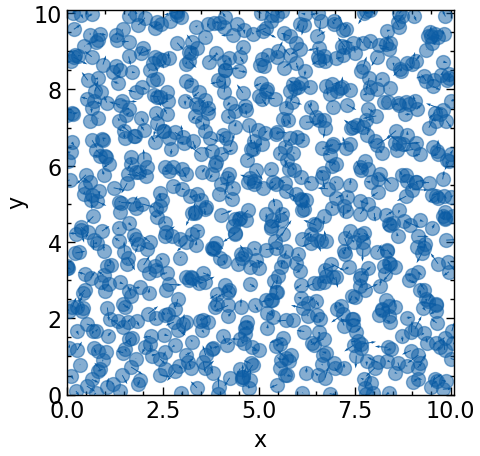

In [10]:
plt.figure(figsize=(5,5))
plt.plot(lj.x,lj.y,'o',ms=10.0,alpha=0.5) # posição das partículas
plt.quiver(lj.x,lj.y,lj.vx,lj.vy,color='C0') # vetor de velocidade

plt.xlim(0,lj.Lx)
plt.ylim(0,lj.Ly)

plt.xlabel('x')
plt.ylabel('y')

Distribuição das partículas

(0.0, 0.2)

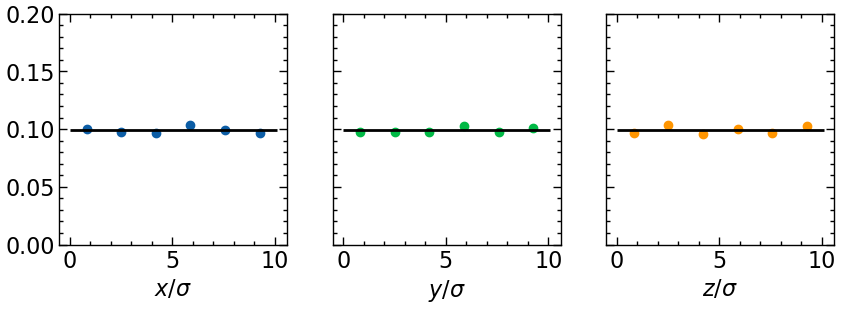

In [11]:
fig, axs = plt.subplots(1, 3, sharey=True,figsize=(10,3))

n, bins = np.histogram(lj.x,bins=6,range=(0,lj.Lx),density=True) # é uma outra forma de fazer histograma
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[0].scatter(meanbins,n,marker='o',color='C0')
axs[0].hlines(y=rho*lj.Lx*lj.Ly/lj.N_atoms,xmin=0,xmax=lj.Lx,color='k')
axs[0].set_xlabel(r'$x/\sigma$')

n, bins = np.histogram(lj.y,bins=6,range=(0,lj.Ly),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[1].scatter(meanbins,n,marker='o',color='C1')
axs[1].hlines(y=rho*lj.Lx*lj.Lz/lj.N_atoms,xmin=0,xmax=lj.Ly,color='k')
axs[1].set_xlabel(r'$y/\sigma$')

n, bins = np.histogram(lj.z,bins=6,range=(0,lj.Lz),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[2].scatter(meanbins,n,marker='o',color='C2')
axs[2].hlines(y=rho*lj.Ly*lj.Lz/lj.N_atoms,xmin=0,xmax=lj.Lz,color='k')
axs[2].set_xlabel(r'$z/\sigma$')

axs[0].set_ylim(0,0.2)

Distribuição de Velocidades

(0.0, 0.5)

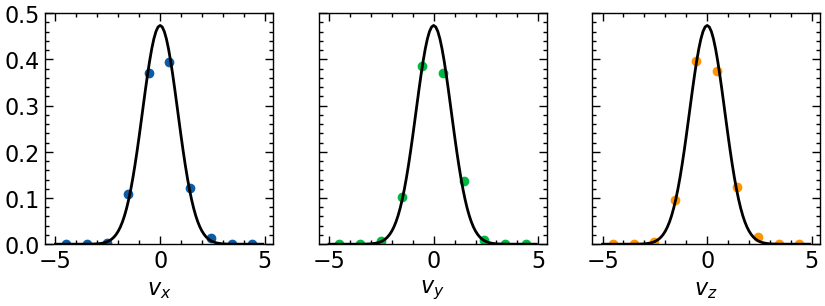

In [12]:
fig, axs = plt.subplots(1, 3, sharey=True,figsize=(10,3))

vx = np.arange(-5,5,0.1)
fvx = np.exp(-vx**2/(2*kT))/np.sqrt(2*np.pi*kT)

n, bins = np.histogram(lj.vx,bins=10,range=(vx.min(),vx.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[0].scatter(meanbins,n,marker='o',color='C0')
axs[0].plot(vx,fvx,'k')
axs[0].set_xlabel(r'$v_x$')

n, bins = np.histogram(lj.vy,bins=10,range=(vx.min(),vx.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[1].scatter(meanbins,n,marker='o',color='C1')
axs[1].plot(vx,fvx,'k')
axs[1].set_xlabel(r'$v_y$')

n, bins = np.histogram(lj.vz,bins=10,range=(vx.min(),vx.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[2].scatter(meanbins,n,marker='o',color='C2')
axs[2].plot(vx,fvx,'k')
axs[2].set_xlabel(r'$v_z$')

axs[0].set_ylim(0,0.5)

Gráfico da evolução de $E$, $U$ e $T$ como função dos passos de iteração

Text(0, 0.5, '$k_B T/\\epsilon$')

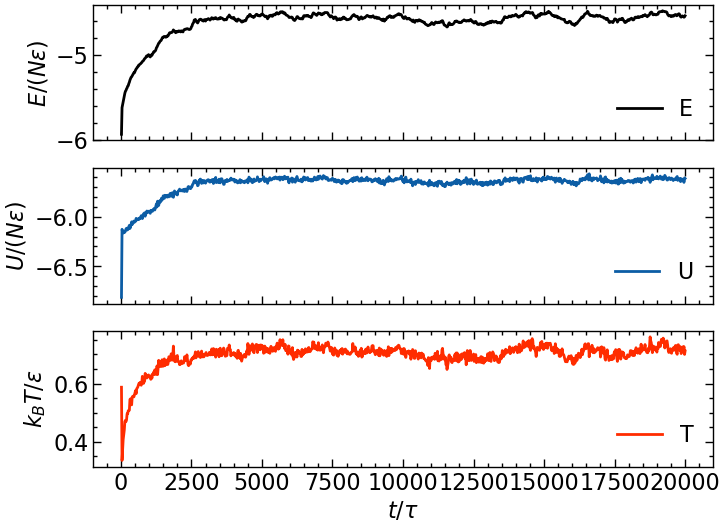

In [13]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(t,E/lj.N_atoms,'k',label='E')
axs[0].legend(loc='best')
axs[0].set_ylabel(r'$E/(N\epsilon)$')

axs[1].plot(t,U/lj.N_atoms,label='U')
axs[1].legend(loc='best')
axs[1].set_ylabel(r'$U/(N\epsilon)$')

axs[2].plot(t,T,color='C3',label='T')
axs[2].legend(loc='best')
axs[2].set_xlabel(r'$t/\tau$')
axs[2].set_ylabel(r'$k_B T/\epsilon$')

## Estatísticas

In [34]:
teq = 5000
subsett = t[t>teq]
subsetT = T[t>teq]
subsetU = U[t>teq]/lj.N_atoms
subsetP = P[t>teq]

In [25]:
Umean = subsetU.mean()

print(Umean)

-5.6307975164684905


In [26]:
sigmaU = subsetU.std()

print(sigmaU)

0.02217327877313116


$$U/N\epsilon = -3.43 \pm 0.02 $$

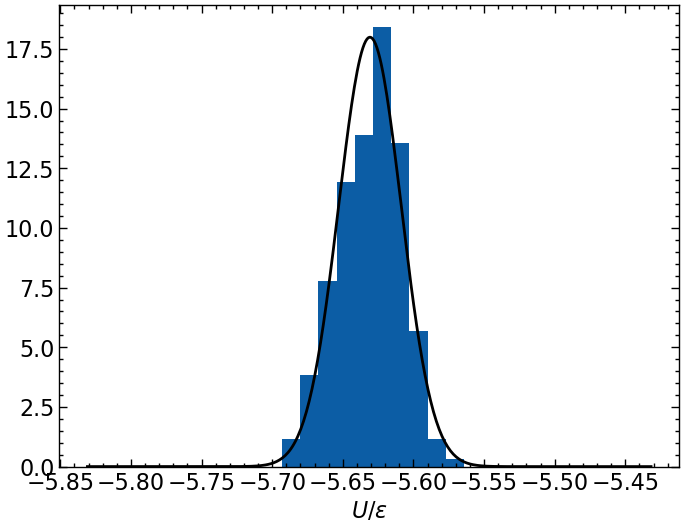

In [27]:
plt.hist(subsetU,density=True)
plt.xlabel(r'$U/\epsilon$')

uarray = Umean+np.arange(-0.2,0.2,0.001)
plt.plot(uarray,np.sqrt(1/(2*np.pi*sigmaU**2))*np.exp(-0.5*(uarray-Umean)**2/sigmaU**2),color='k')

In [28]:
Tmean = subsetT.mean()

print(Tmean)

0.7080294447682289


In [29]:
sigmaT = subsetT.std()

print(sigmaT)

0.018160629691492045


$$ k_B T /\epsilon = 1.34 \pm 0.07$$

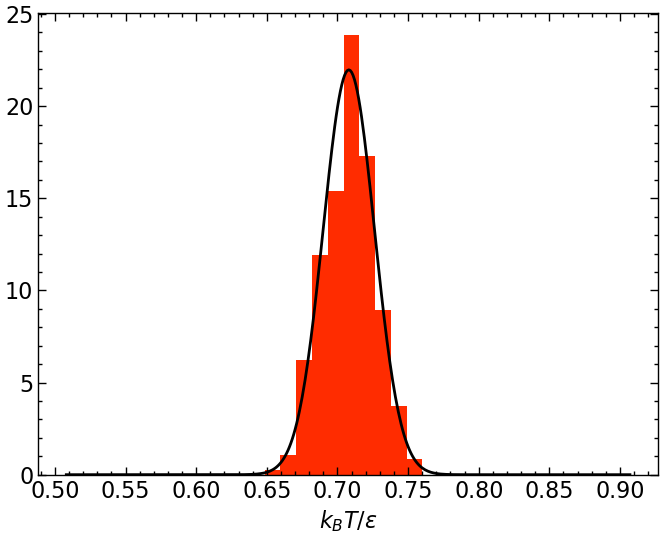

In [30]:
plt.hist(subsetT,density=True,color='C3')
plt.xlabel(r'$k_B T/\epsilon$')

Tarray = Tmean + np.arange(-0.2,0.2,0.001)
plt.plot(Tarray,np.sqrt(1/(2*np.pi*sigmaT**2))*np.exp(-0.5*(Tarray-Tmean)**2/sigmaT**2),color='k')

Pressão

In [35]:
Pmean = subsetP.mean()

print(Pmean)

0.4493571354948816


In [36]:
sigmaP = subsetP.std()

print(sigmaP)

0.11301078842857473


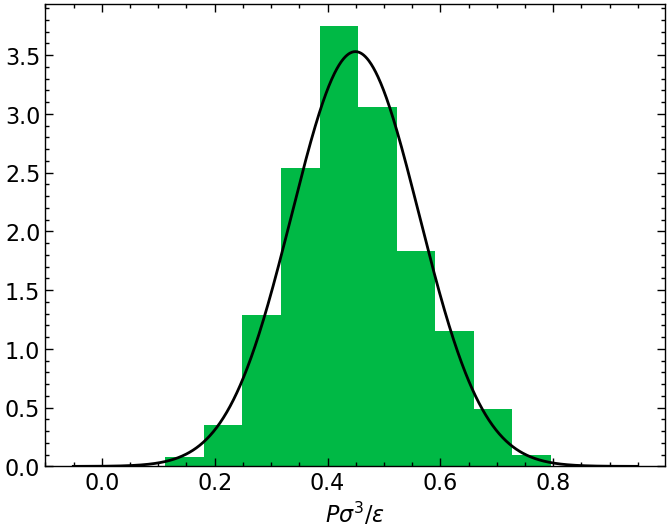

In [41]:
plt.hist(subsetP,color='C1',density=True)
plt.xlabel(r'$P \sigma^3/\epsilon$')

earray = Pmean+np.arange(-0.5,0.5,0.001)
plt.plot(earray,np.sqrt(1/(2*np.pi*sigmaP**2))*np.exp(-0.5*(earray-Pmean)**2/sigmaP**2),color='k')

## Função de Distribuição Radial $g(r)$

In [ ]:
def compute_rdf(ljsystem, r_max, dr):

    # Define histogram bins
    r_edges = np.arange(0.0, r_max + dr, dr)
    r_centers = 0.5 * (r_edges[1:] + r_edges[:-1])
    g_r = np.zeros_like(r_centers)

    # Loop over all unique pairs
    for i in range(ljsystem.N_atoms):
        for j in range(i+1,ljsystem.N_atoms):
            # calcula distancia entre duas particulas
            rx = ljsystem.x[i] - ljsystem.x[j]
            ry = ljsystem.y[i] - ljsystem.y[j]
            rz = ljsystem.z[i] - ljsystem.z[j]
            # testa condição de contorno periodica para imagens
            rx -= np.rint(rx/ljsystem.Lx)*ljsystem.Lx # em x
            ry -= np.rint(ry/ljsystem.Ly)*ljsystem.Ly # em y
            rz -= np.rint(rz/ljsystem.Lz)*ljsystem.Lz # em y
            # calcula modulo da distancia 
            r = np.sqrt(rx**2 + ry**2 + rz**2)
            # monta o histograma
            hist, _ = np.histogram(r, bins=r_edges)
            g_r += 2*hist # contabiliza as duas partículas do par

    # Normalize
    shell_volumes = 4/3 * np.pi * (r_edges[1:]**3 - r_edges[:-1]**3)
    g_r /= (rho * ljsystem.N_atoms * shell_volumes)

    return r_centers, g_r

In [90]:
r, g_r = compute_rdf(lj, r_max=5.0, dr=0.03)

In [91]:
xdata = pd.read_csv('data/rdf-Ar-rhob=0.84-KT=0.71-Xray.txt', sep='\t')

sigmaAr = 3.4 #angstrom

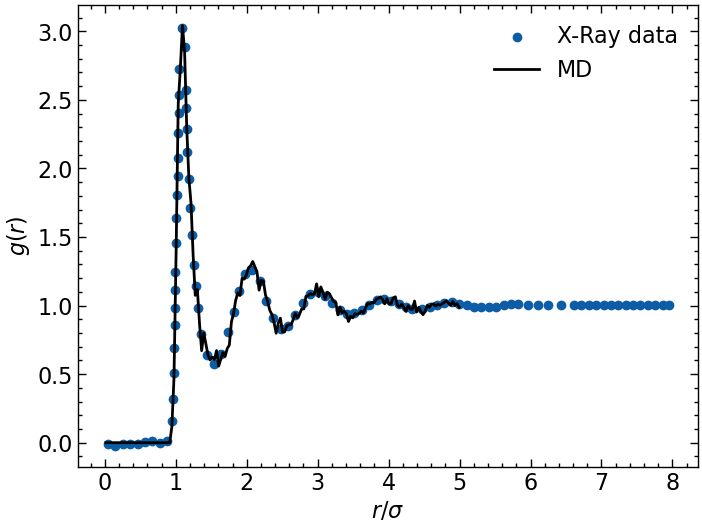

In [92]:
plt.scatter(xdata['r']/sigmaAr,xdata['g_r'],label='X-Ray data')
plt.plot(r,g_r,'k',label='MD')

plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'$g(r)$')
plt.legend(loc='best')